In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1.0, 1.0)

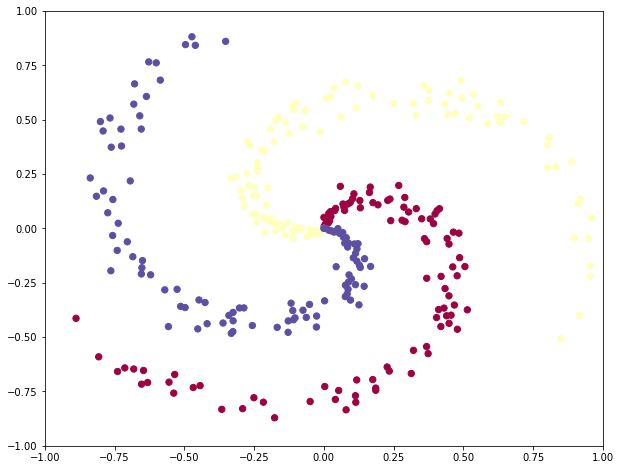

In [2]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))  # SM: data matrix (each row = single example), 300 samples (3 * 100)
y = np.zeros(N*K, dtype='uint8')  # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

In [5]:
# Normally we would want to preprocess the dataset 
# so that each feature has zero mean and unit standard deviation, 
# but in this case the features are already in a nice range from -1 to 1.

#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)  # SM: dimensionality * number of classes
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3  # SM: regularization strength, LAMBDA

# gradient descent loop
num_examples = X.shape[0]
for i in range(150):  # SM: arbitrary number of iterations, ideally stop when loss doesn't decrease much (here ~150 iters)
  
    # evaluate class scores, [N * K]
    scores = np.dot(X, W) + b  # SM: scores has size [300, 3] = [samples, classes]
    if i == 0 :
        print(f"[SM] scores shape = {scores.shape}")

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # SM: [N, K] = [300, 3]

    # SM: compute the loss: average cross-entropy loss and regularization (from formula)
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    # SM: Evaluating this in the beginning (with random parameters) might give us loss = 1.1, 
    # which is -np.log(1.0/3), since with small initial random weights all probabilities assigned to all classes are about one third.
    if i % 10 == 0:
        print(f"iteration {i}: loss {loss}")

    # SM: compute the gradient on scores (from formula)
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # SM: backpropate the gradient to the parameters (W,b) (from formula)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # regularization gradient

    # perform a parameter update
    W += -step_size * dW  # negative gradient direction to decrease the loss
    b += -step_size * db

[SM] scores shape = (300, 3)
iteration 0: loss 1.0991639006021696
iteration 10: loss 0.9180099544298367
iteration 20: loss 0.8518116602464165
iteration 30: loss 0.8224841237822416
iteration 40: loss 0.8076643874668537
iteration 50: loss 0.7994931373346441
iteration 60: loss 0.7947076555990763
iteration 70: loss 0.791780523879618
iteration 80: loss 0.7899310938370327
iteration 90: loss 0.7887332171303734
iteration 100: loss 0.7879421621579663
iteration 110: loss 0.7874116650294096
iteration 120: loss 0.7870514788477739
iteration 130: loss 0.7868044628209436
iteration 140: loss 0.7866336647610392


In [9]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print(f"training accuracy: {np.mean(predicted_class == y)}")

training accuracy: 0.49


(-1.8712034092398278, 1.8687965907601756)

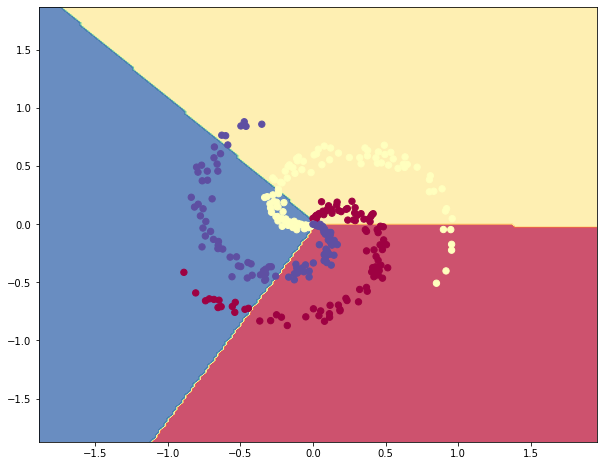

In [10]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

In [11]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(5000):  # SM again, arbitrary (~5000 loss stabilises)

    # SM: evaluate class scores, [N, K], 2-layers = 2 sets of weights
    hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N, K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)  # SM: same as before but with 2 layers
    loss = data_loss + reg_loss
    if i % 500 == 0:
        print(f"iteration {i}: loss {loss}")

    # SM: same as before, compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # SM: backpropate the gradient to the parameters, now need 2 steps (as 2 layers net)
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # SM: backprop the ReLU non-linearity. Next, we have to backpropagate the ReLU non-linearity. 
    # This turns out to be easy because ReLU during the backward pass is effectively a switch.
    # The ReLU unit lets the gradient pass through unchanged if its input was greater than 0, 
    # but kills it if its input was less than zero during the forward pass.
    dhidden[hidden_layer <= 0] = 0
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.098700415926646
iteration 500: loss 0.39365783274547816
iteration 1000: loss 0.31270642288267436
iteration 1500: loss 0.2691672652961543
iteration 2000: loss 0.2584296509427455
iteration 2500: loss 0.2527332535521907
iteration 3000: loss 0.24914819016700987
iteration 3500: loss 0.247202964374344
iteration 4000: loss 0.24635873880009623
iteration 4500: loss 0.2455225464463346
iteration 5000: loss 0.2448147311540444
iteration 5500: loss 0.24464788417142797
iteration 6000: loss 0.24455197249630753
iteration 6500: loss 0.2445040660767
iteration 7000: loss 0.24447064771913762
iteration 7500: loss 0.2444538412954202
iteration 8000: loss 0.24443498443417294
iteration 8500: loss 0.24442624380557817
iteration 9000: loss 0.24440405430675677
iteration 9500: loss 0.2443941174577574


In [333]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.98


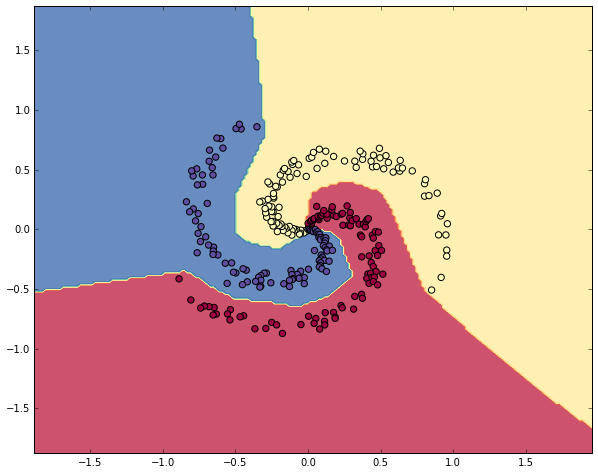

In [336]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')